In [112]:
import pickle
import numpy as np
from astropy.table import Table
from astropy.io import ascii
import os
import math
import requests
import json
from datetime import datetime
from astropy.table import Table
from astropy.time import Time
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib
import getpass
import warnings
import pandas
import time
import subprocess
import logging
import webbrowser
import glob
from datetime import *
import scipy.signal
from os import listdir
import sqlite3
from astropy.modeling import models
from astropy import units as u

from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum


np.random.seed(1)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


In [113]:
"""Read in the file containing a list of the sources you are interested in along with their redshifts, in two columns
    """

f = ascii.read("SLSNe - I copy.txt") #ascii file containing the names of sources and their redshifts
targets = f['col1']
redshift = f['col2']

In [114]:
def fetch_ZTF_spectrum(target_id, user, passw, specfilter=False, program_idx=0):
    """Returns list of all available spectra(data url paths) for a given ZTF target.

    Input
    ------
    target_id: ZTF name of source (str)
    user: Username for login cridentials for GROWTH Marshall (str)
    passw: Password for login cridentials for GROWTH Marshall (str)
    specfilter: True; Choose a single spectrum based of of the peak magnitude (PM) (+7 days after PM or -4 before PM) (bool)
    specfilter: False; Choose multiple spectra uploaded in the Marshall (bool)

    Output
    ------
    list_spec: List of download paths (from marshall) in format: spectra/data/ZTFid_date_inst_vn.ascii (list)
    """

    programidx = program_idx # Superluminous: 10
    r = requests.post('http://skipper.caltech.edu:8080/cgi-bin/growth/list_program_sources.cgi', auth=(user, passw), data = {'programidx': str(programidx)})
    sources = json.loads(r.text) # preliminary information on CLU objects
    list_spec, sd, dat_url, dat_inst = [], [], [], []

    for i in enumerate(sources_clu):
        name = i[1]['name'] # name generated from marshall

        if name == target_id: # if you find the ZTF_id you have queried
            marsh_info = i[1] # fetch marshall information!
            s = requests.post('http://skipper.caltech.edu:8080/cgi-bin/growth/source_summary.cgi', auth=(user, passw), data = {'sourceid': str(marsh_info['id'])})
            sourceDict = json.loads(s.text)

            # Spectral and Photometric information --
            spec = sourceDict['uploaded_spectra'] # information on spectroscopy
            photometry_info = sourceDict['uploaded_photometry'] # information on photometry

            N_spec = len(spec) # number of available spectra! -- check for uniqueness? [NOTE!]
            
            for spectra_path in spec:
                list_spec.append(str(spectra_path['datapath'])) # append datapaths...
            return (list_spec)

In [115]:
def download_spectra(data_path, target_id, date_dir_name, dtype='no_header'):
    """Downloads .ascii files from GROWTH Marshall for given ZTF object.

    Input
    -----
    data_path: Download URL from GROWTH Marshall -- usually called from Fetch_ZTF_Spectrum (str)
    target_id: ZTF name of source (str)
    date_dir_name: daving date directory you will be storing the downloaded files (str)
    dtype: data type you want for the ascii files. Usually no_header will not read the first row of the ascii file.

    Output
    ------
    Creates /spectra and /summary directories and downloads ascii file data path given.

    """
    # GROWTH Marshall url where data is available
    download_url = "http://skipper.caltech.edu:8080/growth-data/"

    # Complete path to url downloading data
    data_path_mod = data_path.split("/")[2].split('.')[0] #ZTFid_date_inst_vn

    try:
        # Stich final directories to the directory containing the data
        final_path_to_data = download_url + "spectra/data/" + data_path_mod + ".ascii"
        #print ("this is the final path --> ")
        #print (final_path_to_data)
    except:
        #print ("This file you have requested is not available!")
        return (None)

    # Make a new directory with the ZTF name
    bash1 = subprocess.run("mkdir data/%s/%s"%(date_dir_name, target_id), shell=True)
    bash2 = subprocess.run("mkdir data/%s/%s/spectra"%(date_dir_name, target_id), shell=True) # create the spectra dir in the ZTF target dir

    # Fetch data from custom url
    data = ascii.read("%s"%final_path_to_data, format=dtype)
    # clean from nan values
    rmv_nan = np.where(np.isnan([data['col1'], data['col2']]))
    data.remove_rows(rmv_nan[1]) # will remove NaN identified values!
    min_lambda = min(data['col1']) # minimum wavelength
    max_lambda = max(data['col1'])# maximum wavelength

    # Generally in this directory we will have: ".asii", ".output"
    download_spectrum = ascii.write(data, "data/%s/%s/spectra/%s.ascii"%(date_dir_name, target_id, data_path_mod), format=dtype)
    stored_spectrum = "data/%s/%s/spectra/%s.ascii"%(date_dir_name, target_id, data_path_mod)
    return (stored_spectrum)

In [119]:
def plot_smoothed_spectra(a, b, fig_name, constant = 25, low_xlim = 3000, up_xlim = 7000, low_ylim = -30, up_ylim = 30):
    
    """Returns a plot of all the spectra arranged by mjd in ascending order for every source, with (scaled flux + constant) on 
    Y axis and Rest wavelength on X.
    
    Input
    ------
    a(required): index of the source in the list to start plotiing from (int)
    b(required): index of the source in the list to end plotiing at (int)
    fig_name(required): Name the pdf of the plot created (str)
    constant(Optional, Default value. = 25): adds a constant to the calculated flux, value changes for every spectrum to shift them down on the 
                                             Y axis, to avoid overlap, hange value for an even distribution about zero (int), default 20
    low_xlim(Optional, Default value. = 2000): lower limit of x-axis (int)
    up_xlim(Optional, Default value. = 7000): upper limit of x-axis (int)
    low_ylim(Optional, Default value. = -30): lower limit of y-axis (int)
    up_ylim"(Optional, Default value. = 30): upper limit of y-axis (int)

    
    Output
    ------
    Creats a plots directory in your working directory and saves the pdfs to it
    """


    plotx = []
    ploty = []

    label = [[],[]]
    text = []

    rest = []
    instrument = np.array([])
    datesss = []
    instrument_sorted = np.array([])
    mistake = []

    for t in targets[a:b]: # Go through the list of ZTFnames in the ascii file
        print (t)

        directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

        for d in directory: # go through all the spectra for a single source
            
            #print (d)

            l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
            #print (l)    
            mistake.append(l)

            inst = l.split("_")[2]
            instrument=np.append(instrument,inst)

            date = l.split("_")[1]      # store just the date from the spectrum name
             

            new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
            #print (new_date)  

            normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

            Julian_date = normal_date.mjd #convert to MJD
            #print(Julian_date)
            datesss.append(Julian_date)

            label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
            #print (label)    

            text.append(label)    #append all the labels to an array to use later
            #text.append(label)

            data = ascii.read(d)    #read in the ascii file
            data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

            # Removing all the rows where either of the values is nan
            data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
            data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

            #Scaling the flux values here
            lam_cut = np.where((data_l>6000) & (data_l<7000))

            #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
            mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

            plotx.append(data_l)
            ploty.append(data_flux/mean) #Scaling flux for plotting

        b = (np.argsort (datesss))

        #print (instrument)

        sorting = np.array(instrument[b])
        #print (sorting)
        instrument_sorted = np.append (instrument_sorted,sorting)
    
    #print(instrument)
    #print (instrument_sorted)

    fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,20))
    ax.set_xlim(low_xlim,up_xlim)
    ax.set_ylim(low_ylim,up_ylim)
    plt.xlabel('Rest Wavelength Å')
    plt.ylabel('Scaled Flux + Constant')
    #plt.yscale('log')

    const = constant  #increment
    count = 0 #increment
    inc = 0
    name = fig_name

    
    for k in zip(plotx,ploty):

        #print(np.array(instrument_sorted[inc]))

        if instrument_sorted[inc] == "Keck1": 
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) #Fit smoothed spectra using Savitzky-Golay filter

        elif instrument_sorted[inc] == "Keck2": 
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

        elif instrument_sorted[inc] == "P200":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument_sorted[inc] == "P60":
            yhat = scipy.signal.savgol_filter(k[1], 31, 3)

        elif instrument_sorted[inc] == "LT":
            yhat = scipy.signal.savgol_filter(k[1], 31, 3)

        elif instrument_sorted[inc] == "NOT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

        elif instrument_sorted[inc] == "VLT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument_sorted[inc] == "DCT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument_sorted[inc] == "WHT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        elif instrument_sorted[inc] == "NTT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        # Plotting the spectrum name and date for every spectrum
        y_temp = k[1] + const   # Scaling flux values and saving in a temporary variable
        text_pos_y = np.median(y_temp)    # defining the location on y-axis
        ax.text((up_xlim+200), (text_pos_y), text[count], size=12) 

        #print (text[count])
        variable = text[count][0]    # Only select the name of sourcec by indexing
        #print (variable)
        r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
        z = (1 + r)

        ax.plot(k[0]/z, k[1]+const,  color = '0.7')   #Plotting the x in rest wavelength and y in scaled flux + const  
        ax.plot(k[0]/z, yhat+const, color='red')    #Plotting the x in rest wavelength and y in smoothed spectra + const

        inc += 1
        count = count+1  #to go through the Text array and print appropriate text besides every spectra
        const += -2    #shift the spectra


    # Make a new directory to save the plots   
    bash1 = subprocess.run("mkdir plots", shell=True)    
    plt.savefig("plots/%s"%name, format = 'pdf', bbox_inches = 'tight')
    plt.show()

In [280]:
def plot_spectra(a, b, fig_name, constant = 25, low_xlim = 3000, up_xlim = 7000, low_ylim = -30, up_ylim = 30):
    
    """Returns a plot of all the spectra arranged by mjd in ascending order for every source, with (scaled flux + constant) on 
    Y axis and Rest wavelength on X.
    
    Input
    ------
    a(required): index of the source in the list to start plotiing from (int)
    b(required): index of the source in the list to end plotiing at (int)
    fig_name(required): Name the pdf of the plot created (str)
    constant(Optional, Default value. = 25): adds a constant to the calculated flux, value changes for every spectrum to shift them down on the 
                                             Y axis, to avoid overlap, hange value for an even distribution about zero (int), default 20
    low_xlim(Optional, Default value. = 2000): lower limit of x-axis (int)
    up_xlim(Optional, Default value. = 7000): upper limit of x-axis (int)
    low_ylim(Optional, Default value. = -30): lower limit of y-axis (int)
    up_ylim"(Optional, Default value. = 30): upper limit of y-axis (int)

    
    Output
    ------
    Creats a plots directory in your working directory and saves the pdfs to it
    """


    plotx = []
    ploty = []

    label = [[],[]]
    text = []

    rest = []
    instrument = np.array([])
    datesss = []
    instrument_sorted = np.array([])
    mistake = []

    for t in targets[a:b]: # Go through the list of ZTFnames in the ascii file
        print (t)

        directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

        for d in directory: # go through all the spectra for a single source
            
            #print (d)

            l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
            #print (l)    
            mistake.append(l)

            inst = l.split("_")[2]
            instrument=np.append(instrument,inst)

            date = l.split("_")[1]      # store just the date from the spectrum name
             

            new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
            #print (new_date)  

            normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

            Julian_date = normal_date.mjd #convert to MJD
            #print(Julian_date)
            datesss.append(Julian_date)

            label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
            #print (label)    

            text.append(label)    #append all the labels to an array to use later
            #text.append(label)

            data = ascii.read(d)    #read in the ascii file
            data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

            # Removing all the rows where either of the values is nan
            data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
            data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

            #Scaling the flux values here
            lam_cut = np.where((data_l>6000) & (data_l<7000))

            #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
            mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

            plotx.append(data_l)
            ploty.append(data_flux/mean) #Scaling flux for plotting
            

    fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,20))
    ax.set_xlim(low_xlim,up_xlim)
    ax.set_ylim(low_ylim,up_ylim)
    plt.xlabel('Rest Wavelength Å')
    plt.ylabel('Scaled Flux + Constant')
    #plt.yscale('log')

    const = constant  #increment
    count = 0 #increment
    inc = 0
    name = fig_name

    #print (text)
    #print (instrument)
    
    for k in zip(plotx,ploty):
        
        #print(instrument[inc])
        #print(text[inc])
        
        if instrument[inc] == "Keck1": 
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) #Fit smoothed spectra using Savitzky-Golay filter

        if instrument[inc] == "Keck2": 
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

        if instrument[inc] == "P200":
            yhat = scipy.signal.savgol_filter(k[1], 81, 3)

        if instrument[inc] == "P60":
            yhat = scipy.signal.savgol_filter(k[1], 21, 4)

        if instrument[inc] == "LT":
            yhat = scipy.signal.savgol_filter(k[1], 31, 3)

        if instrument[inc] == "NOT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3) 

        if instrument[inc] == "VLT":
            yhat = scipy.signal.savgol_filter(k[1], 81, 3)

        if instrument[inc] == "DCT":
            yhat = scipy.signal.savgol_filter(k[1], 51, 3)

        if instrument[inc] == "WHT":
            yhat = scipy.signal.savgol_filter(k[1], 81, 3)

        if instrument[inc] == "NTT":
            yhat = scipy.signal.savgol_filter(k[1], 31, 3)
            

        # Plotting the spectrum name and date for every spectrum
        y_temp = k[1] + const   # Scaling flux values and saving in a temporary variable
        text_pos_y = np.median(y_temp)    # defining the location on y-axis
        ax.text((up_xlim+200), (text_pos_y), text[inc], size=12) 

        #print (text[count])
        variable = text[inc][0]    # Only select the name of sourcec by indexing
        #print (variable)
        r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
        #print (r)
        z = (1 + r)

        ax.plot(k[0]/z, k[1]+const,  color = '0.7')   #Plotting the x in rest wavelength and y in scaled flux + const  
        ax.plot(k[0]/z, yhat+const, color='red')    #Plotting the x in rest wavelength and y in smoothed spectra + const

        inc += 1
        count = count+1  #to go through the Text array and print appropriate text besides every spectra
        const += -2    #shift the spectra


    # Make a new directory to save the plots   
    bash1 = subprocess.run("mkdir plots", shell=True)    
    plt.savefig("plots/%s"%name, format = 'pdf', bbox_inches = 'tight')
    plt.show()

ZTF18abszecm
ZTF18acenqto
ZTF18acxgqxq
ZTF19aarphwc
ZTF19aawsqsc


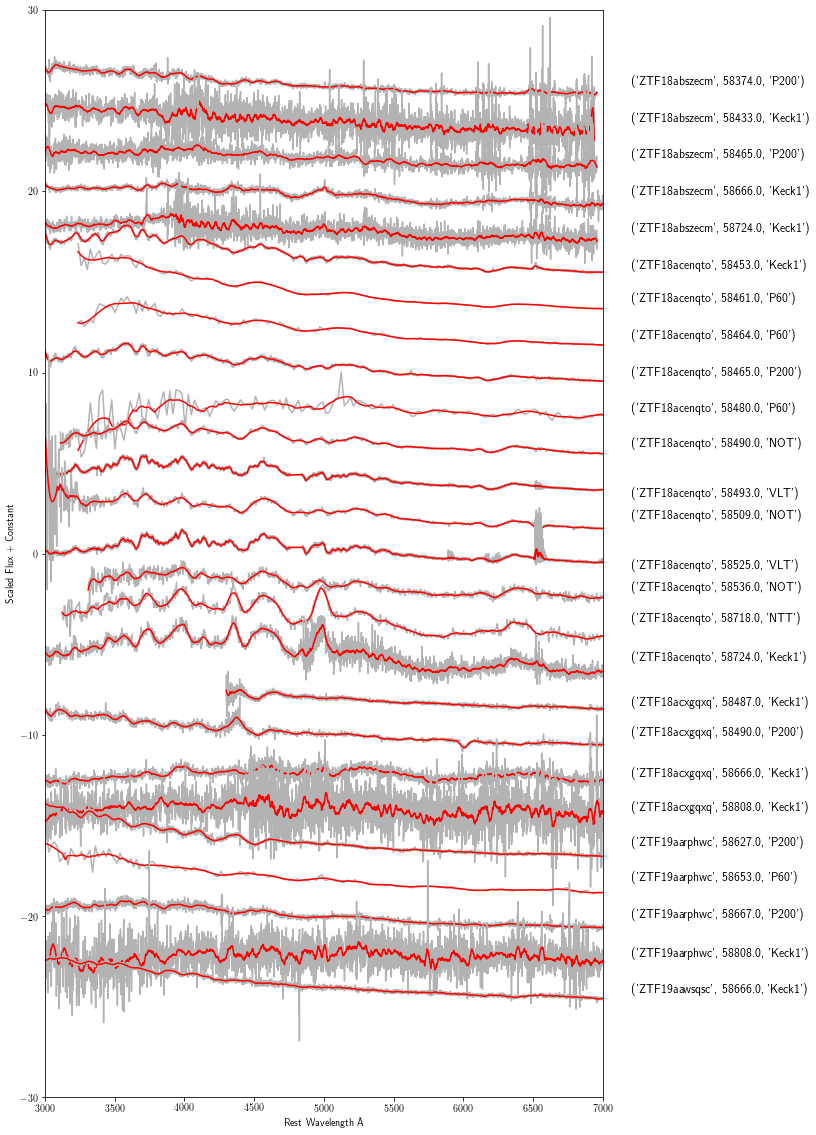

In [281]:
plot_spectra(0, 5, "trial1")

ZTF19aavouyw
ZTF19aaqrime
ZTF19abaeyqw
ZTF18aajqcue
ZTF18aavrmcg


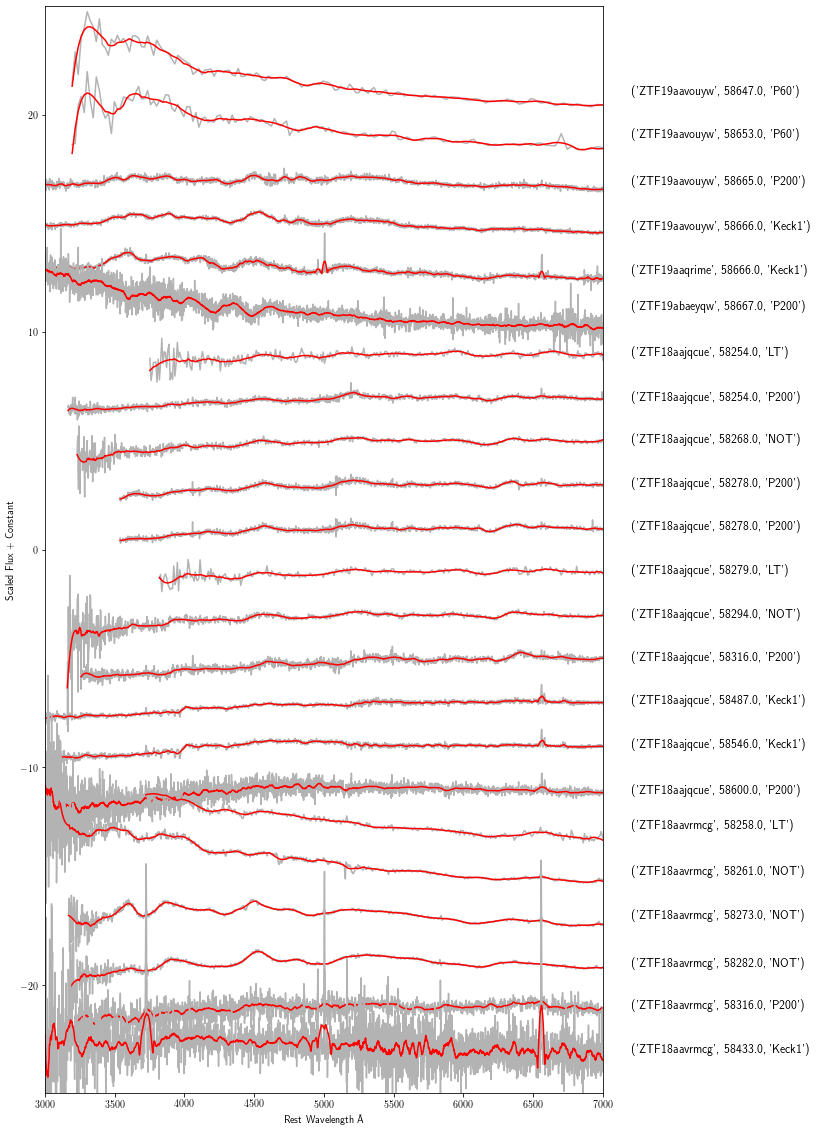

In [282]:
plot_spectra(5, 10, "trial2", 20, 3000, 7000, -25, 25)

ZTF18aazgrfl
ZTF18abjwagv
ZTF18ablwafp
ZTF18abmasep
ZTF18abshezu


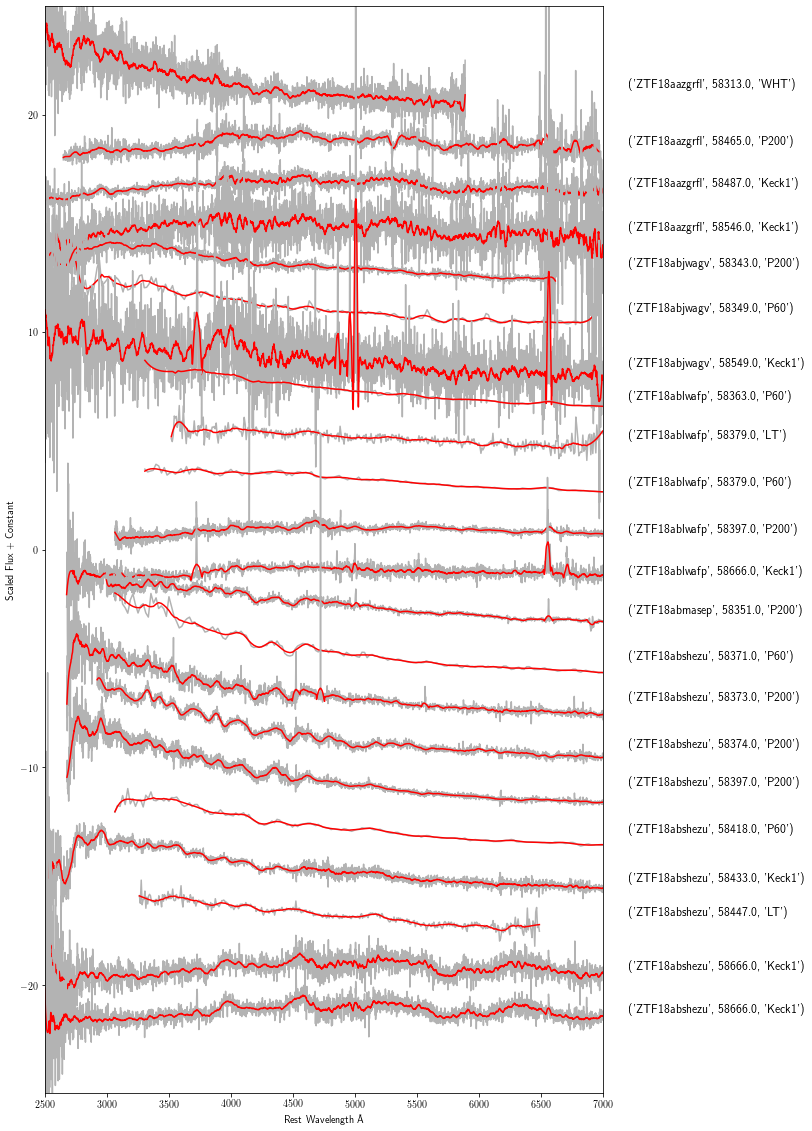

In [283]:
plot_spectra(10, 15, "Trial3", 20, 2500, 7000, -25, 25)

ZTF18abvgjyl
ZTF18acapyww
ZTF18achdidy
ZTF18acqyvag
ZTF18acslpji


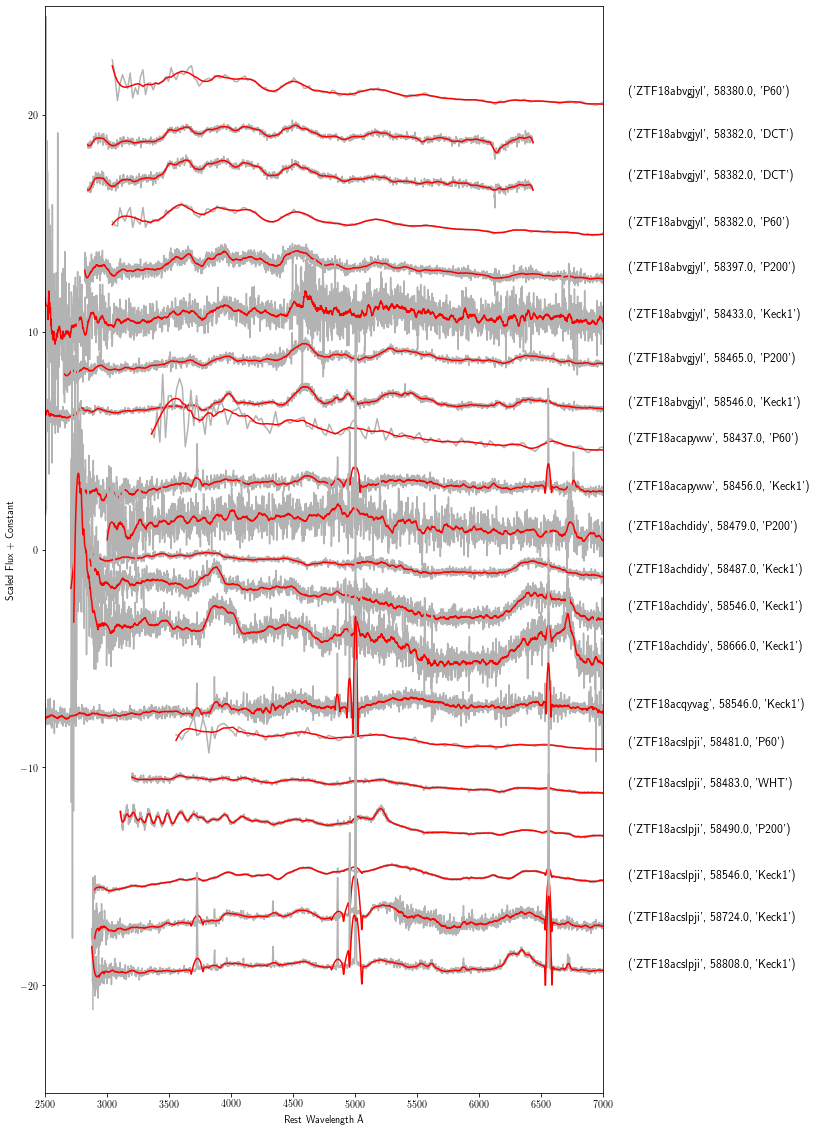

In [284]:
plot_spectra(15, 20, "Trial4", 20, 2500, 7000, -25, 25)

ZTF18acyxnyw
ZTF19aacxrab
ZTF19aajwogx
ZTF19aaknqmp
ZTF19aalbrph


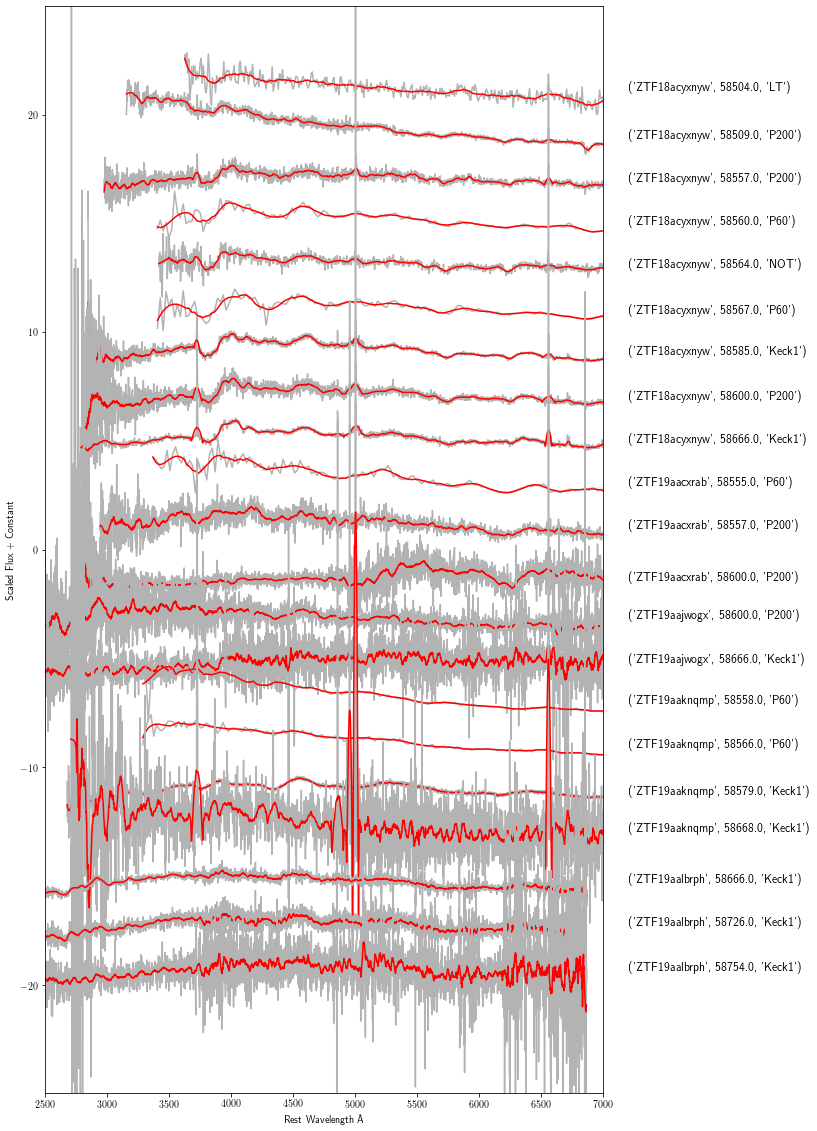

In [285]:
plot_spectra(20, 25, "Trial5", 20, 2500, 7000, -25, 25)

ZTF19aamhhiz
ZTF19aantokv
ZTF19aaohuwc
ZTF19aapaeye
ZTF19aaruixj
ZTF19aasdvfr
ZTF19aauiref
ZTF19aayclnm
ZTF19abdlzyq
ZTF19abfvnns


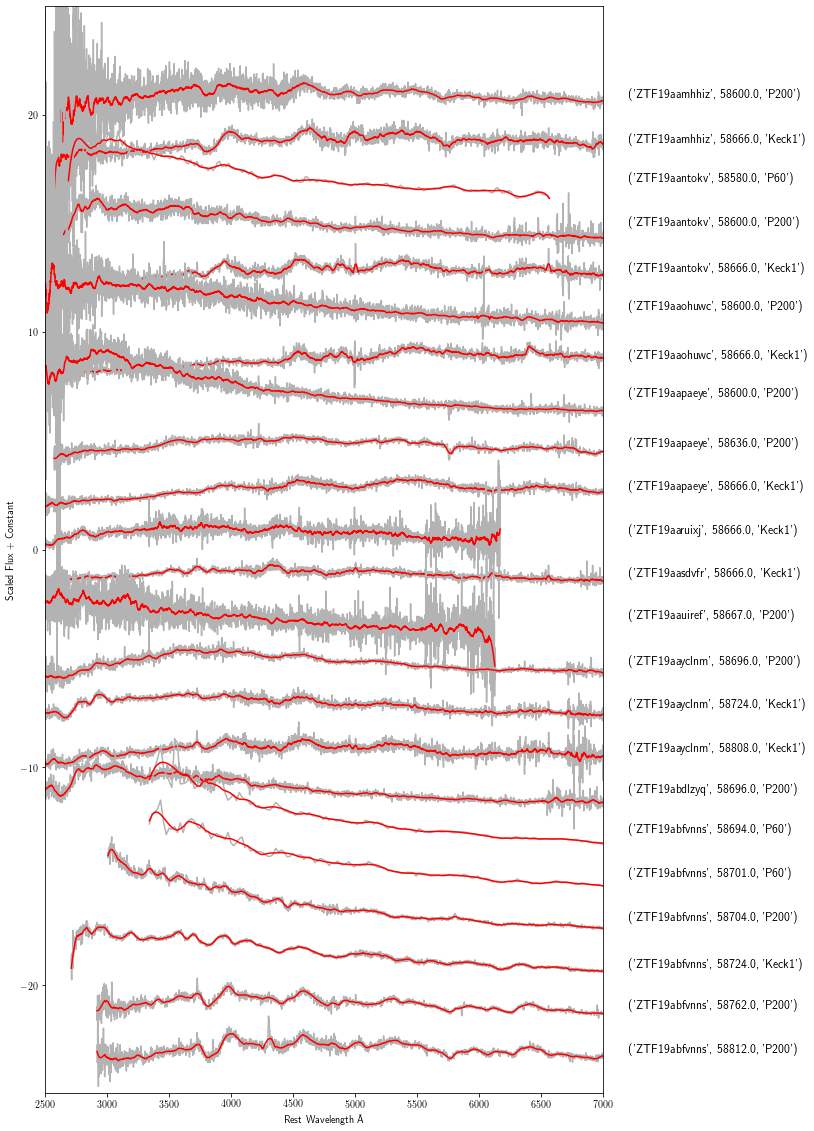

In [286]:
plot_spectra(25, 36, "Trial6", 20, 2500, 7000, -25, 25)

In [321]:
def normalize_spectra(target_name, spectrum, O1, O2, O3, O4, O5, R1=3727.59, R2=3959.83, R3=4115.17, R4=4375.97, R5=4650.71):
    
    
    """Returns a plot of the spectrum with absorbtion features marked for  arranged by mjd in ascending order for every source, with (scaled flux + constant) on 
    Y axis and Rest wavelength on X.
    
    Input
    ------
    target_name (required): Name of the target from the list you are interested in (str)
    spectrum (required): Name of the particular specrtum for which you need the velocity and equivalent width (str)
    
    O1 (required): estimate wavelenth in rest frame of first feature(int)
    O2 (required): estimate wavelenth in rest frame of second feature(int)
    O3 (required): estimate wavelenth in rest frame of third feature(int)
    O4 (required): estimate wavelenth in rest frame of fourth feature(int)
    O5 (required): estimate wavelenth in rest frame of fifth feature(int)
    
    R1 (Optional, Deault value = 3727.59): Theoretical Rest wavelenth  of first feature(int)
    R2 (Optional, Deault value = 3959.83): Theoretical Rest wavelenth  of second feature(int)
    R3 (Optional, Deault value = 4115.17): Theoretical Rest wavelenth of third feature(int)
    R4 (Optional, Deault value = 4375.97): Theoretical Rest wavelenth of fourth feature(int)
    R5 (Optional, Deault value = 4650.71): Theoretical Rest wavelenth of fifth feature(int)

    
    Output
    ------
    Creats a plots directory in your working directory and saves the pdfs to it
    """
    
    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []

    for t in targets:  # Go through the list of ZTFnames in the ascii file

        if t == target_name:

            print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == "data/new/ZTF19aarphwc/spectra/%s"%spectrum:

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string   

                    inst = l.split("_")[2]
                    instrument.append(inst)

                    date = l.split("_")[1]      # store just the date from the spectrum name   

                    new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18" 

                    normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

                    Julian_date = normal_date.mjd #convert to MJD

                    label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling    

                    text.append(label)    #append all the labels to an array to use later

                    data = ascii.read(d)    #read in the ascii file
                    data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

                    # Removing all the rows where either of the values is nan
                    data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
                    data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

                    #Scaling the flux values here
                    lam_cut = np.where((data_l>6000) & (data_l<7000))

                    #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
                    mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

                    plotx.append(data_l)
                    ploty.append(data_flux/mean) #Scaling flux for plotting


            flux = np.array([])
            wavelength = np.array([])

            fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,5))

            ax.set_xlim(3000,5000)
            ax.set_ylim(-1,3)
            ax.set_xlabel('Rest Wavelength Å')
            ax.set_ylabel('Normalized Scaled Flux')

            count = 0 #increment
            inc = 0

            for k in zip(plotx,ploty):

                print("\n"text[count])

                y_temp = k[1]   # Scaling flux values and saving in a temporary variable
                text_pos_y = np.median(y_temp)    # defining the location on y-axis
                ax.text(5200, (text_pos_y), text[count], size=12)
                
                plt.axvline(R1, color = 'green')
                plt.axvline(R2, color = 'green')
                plt.axvline(R3, color = 'green')
                plt.axvline(R4, color = 'green')
                plt.axvline(R5, color = 'green')

                variable = text[count][0]    # Only select the name of sourcec by indexing

                r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
                z = (1 + r)

                spectrum = Spectrum1D(flux = k[1]* u.Unit('W m-2 angstrom-1 sr-1'), spectral_axis = (k[0]/z)*u.Angstrom)

                g1_fit = fit_generic_continuum(spectrum)

                y_continuum_fitted = g1_fit((k[0]/z)* u.Angstrom)

                spec_normalized = spectrum / y_continuum_fitted
                yhat = scipy.signal.savgol_filter(spec_normalized.flux, 51, 3)

                flux = spec_normalized.flux
                wavelength = spec_normalized.spectral_axis


                #O1 = np.where ((wavelength > 3605*u.Angstrom) & (wavelength < 3655*u.Angstrom))
                O1 = np.where ((wavelength > (O1 - 50)*u.Angstrom) & (wavelength < (O1 + 50)*u.Angstrom))
                
                O1_flux = min(yhat[O1])
                O1_index = np.where(yhat == O1_flux)
                O1_min = wavelength[O1_index]
                O1_min2 = k[0][O1_index]
                #print ("Rest_1: %s"%O1_min)
                #print ("Observed_1: %s"%O1_min2)

                velocity1 = (abs(O1_min - (3727.59*u.Angstrom))/(3727.59*u.Angstrom))*(3*pow(10,5))
                print ("Rest_1: %s,"%O1_min, "Velocity1 is : %s km/s"%velocity1)
                

                #O2 = np.where ((wavelength >  3820*u.Angstrom) & (wavelength < 3870*u.Angstrom))
                O2 = np.where ((wavelength >  (O2 - 50)*u.Angstrom) & (wavelength < (O2 + 50)*u.Angstrom))
                
                O2_flux = min(yhat[O2])
                O2_index = np.where(yhat == O2_flux)
                O2_min = wavelength[O2_index]
                O2_min2 = k[0][O2_index]
                #print ("Rest_2: %s"%O2_min)
                #print ("Observed_2: %s"%O2_min2)

                velocity2 = (abs(O2_min - (3959.83*u.Angstrom))/(3959.83*u.Angstrom))*(3*pow(10,5))
                print ("Rest_2: %s,"%O2_min, "Velocity2 is : %s km/s"%velocity2)

                
                #O3 = np.where ((wavelength >  3970*u.Angstrom) & (wavelength < 4120*u.Angstrom))
                O3 = np.where ((wavelength >  (O3 - 50)*u.Angstrom) & (wavelength < (O3 + 50)*u.Angstrom))
                
                O3_flux = min(yhat[O3])
                O3_index = np.where(yhat == O3_flux)
                O3_min = wavelength[O3_index]
                O3_min2 = k[0][O3_index]
                #print ("Rest_3: %s"%O3_min)
                #print ("Observed_3: %s"%O3_min2) 

                velocity3 = (abs(O3_min - (4115.17*u.Angstrom))/(4115.17*u.Angstrom))*(3*pow(10,5))
                print ("Rest_3: %s,"%O3_min, "Velocity3 is : %s km/s"%velocity3)

                
                #O4 = np.where ((wavelength >  4205*u.Angstrom) & (wavelength < 4255*u.Angstrom))
                O4 = np.where ((wavelength >  (O4 - 50)*u.Angstrom) & (wavelength < (O4 + 50)*u.Angstrom))
                
                O4_flux = min(yhat[O4])
                O4_index = np.where(yhat == O4_flux)
                O4_min = wavelength[O4_index]
                O4_min2 = k[0][O4_index]
                #print ("Rest_4: %s"%O4_min)
                #print ("Observed_4: %s"%O4_min2) 

                velocity4 = (abs(O4_min - (4375.97*u.Angstrom))/(4375.97*u.Angstrom))*(3*pow(10,5))
                print ("Rest_4: %s,"%O4_min, "Velocity4 is : %s km/s"%velocity4)

                
                #O5 = np.where ((wavelength >  4490*u.Angstrom) & (wavelength < 4540*u.Angstrom))
                O5 = np.where ((wavelength >  (O5 - 50)*u.Angstrom) & (wavelength < (O5 + 50)*u.Angstrom))
                
                O5_flux = min(yhat[O5])
                O5_index = np.where(yhat == O5_flux)
                O5_min = wavelength[O5_index]
                O5_min2 = k[0][O5_index]
                #print ("Rest_4: %s"%O5_min)
                #print ("Observed_4: %s"%O5_min2) 


                velocity5 = (abs(O5_min - (4650*u.Angstrom))/(4650*u.Angstrom))*(3*pow(10,5))
                print ("Rest_5: %s,"%O5_min, "Velocity is : %s km/s"%velocity5)

                plt.plot(spec_normalized.spectral_axis, spec_normalized.flux, color ='lightblue')
                ax.plot(k[0]/z, yhat, color='darkblue')    #Plotting the x in rest wavelength and y in smoothed spectra + const
                 
                    
                Oxygen1 = O1_min/u.Angstrom
                Oxygen2 = O2_min/u.Angstrom
                Oxygen3 = O3_min/u.Angstrom
                Oxygen4 = O4_min/u.Angstrom
                Oxygen5 = O5_min/u.Angstrom
                
                plt.axvline(Oxygen1,color = 'orange')
                plt.axvline(Oxygen2, color = 'orange')
                plt.axvline(Oxygen3, color = 'orange')
                plt.axvline(Oxygen4, color = 'orange')
                plt.axvline(Oxygen5, color = 'orange')    
                    
                inc += 1
                count = count+1  #to go through the Text array and print appropriate text besides every spectra

                bash1 = subprocess.run("mkdir plots", shell=True) 
                plt.show()


SyntaxError: invalid syntax (<ipython-input-321-48ffeedb1b32>, line 99)

In [322]:
def equivalent_width(target_name, spectrum, O1_min, O1_max, O2_min, O2_max, O3_min, O3_max, O4_min, O4_max, O5_min, O5_max):
    
    plotx = []
    ploty = []

    label = [[],[]]
    text = []
    rest = []
    instrument = []

    #target_name = "ZTF19aarphwc"
    #spectrum = "ZTF19aarphwc_20190524_P200_v1.ascii"

    for t in targets:  # Go through the list of ZTFnames in the ascii file

        if t == target_name:

            #print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == "data/new/ZTF19aarphwc/spectra/%s"%spectrum:

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
                    #print (l)    

                    inst = l.split("_")[2]
                    instrument.append(inst)

                    date = l.split("_")[1]      # store just the date from the spectrum name
                    #print (date)     

                    new_date = (date[0:4] + "-" + date[4:6] + "-" + date[6:8]) # change the date format from "20181018" to "2018-10-18"
                    #print (new_date)  

                    normal_date = Time(new_date, format='iso') #convert to the acceptable format to change to MJD

                    Julian_date = normal_date.mjd #convert to MJD

                    label = (l.split("_")[0], Julian_date, l.split("_")[2]) #storing the required name and date of the spectrum for labeling
                    #print (label)    

                    text.append(label)    #append all the labels to an array to use later

                    data = ascii.read(d)    #read in the ascii file
                    data_l, data_flux = data['col1'], data['col2'] # first define as variables to store the flux and wavelength values

                    # Removing all the rows where either of the values is nan
                    data_l, data_flux = data_l[~np.isnan(data_l)], data_flux[~np.isnan(data_l)] # Only choosing the values for both columns where wavelength is not nan
                    data_l, data_flux = data_l[~np.isnan(data_flux)], data_flux[~np.isnan(data_flux)] # Only choosing the values for both columns where flux is not nan

                    #Scaling the flux values here
                    lam_cut = np.where((data_l>6000) & (data_l<7000))

                    #print ("The mean you're selecting: %s"%np.mean(data_flux[lam_cut]))
                    mean = np.mean(data_flux[lam_cut])   # Take the mean of only the values of flux between 6000Å to 7000Å

                    plotx.append(data_l)
                    ploty.append(data_flux/mean) #Scaling flux for plotting

            #print (instrument)

            flux = np.array([])
            wavelength = np.array([])

            const = 0   #increment
            count = 0 #increment
            inc = 0

            for k in zip(plotx,ploty):

    
                #print (text[count])
                variable = text[count][0]    # Only select the name of sourcec by indexing
              
                r = redshift[np.where(variable == targets)]   # Selecting the value of redshift at the target index where the variable name matches target name
                z = (1 + r)

                spectrum = Spectrum1D(flux = k[1]* u.Unit('W m-2 angstrom-1 sr-1'), spectral_axis = (k[0]/z)*u.Angstrom)

                g1_fit = fit_generic_continuum(spectrum)

                y_continuum_fitted = g1_fit((k[0]/z)* u.Angstrom)

                spec_normalized = spectrum / y_continuum_fitted
                yhat = scipy.signal.savgol_filter(spec_normalized.flux, 51, 3)

                flux = spec_normalized.flux
                wavelength = spec_normalized.spectral_axis

                L1min = np.where ((wavelength > (O1_min - 50)*u.Angstrom) & (wavelength < (O1_min + 50)*u.Angstrom))
                L1min_flux = max(yhat[L1min])
                L1min_index = np.where(yhat == L1min_flux)
                L1min_rest = wavelength[L1min_index]
                L1min_observed = k[0][L1min_index]
                #print ("\n\n Rest_L1min: %s"%L1min_rest)
                #print ("Observed_L1min: %s"%L1min_observed)

                L1max = np.where ((wavelength >  (O1_max - 50)*u.Angstrom) & (wavelength < (O1_max + 50)*u.Angstrom))
                L1max_flux = max(yhat[L1max])
                L1max_index = np.where(yhat == L1max_flux)
                L1max_rest = wavelength[L1max_index]
                L1max_observed = k[0][L1max_index]
                #print (" Rest_L1max: %s"%L1max_rest) 
                #print ("Observed_L1max: %s"%L1max_observed)

                pEW1_rest = L1max_rest - L1min_rest
                pEW1_observed = L1max_observed - L1min_observed

                print ("Eqivalent width for O1 is %s" %pEW1_rest)
                #print ("Eqivalent width for O1 from observed is %s" %pEW1_observed)

                L2min = np.where ((wavelength >  (O2_min - 50)*u.Angstrom) & (wavelength < (O2_min + 50)*u.Angstrom))
                L2min_flux = max(yhat[L2min])
                L2min_index = np.where(yhat == L2min_flux)
                L2min_rest = wavelength[L2min_index]
                L2min_observed = k[0][L2min_index]
                #print ("\n\n Rest_L2min: %s"%L2min_rest)
                #print ( "Observed_L2min: %s"%L2min_observed)


                L2max = np.where ((wavelength >  (O2_max - 50)*u.Angstrom) & (wavelength < (O2_max + 50)*u.Angstrom))
                L2max_flux = max(yhat[L2max])
                L2max_index = np.where(yhat == L2max_flux)
                L2max_rest = wavelength[L2max_index]
                L2max_observed = k[0][L2max_index]
                #print (" Rest_L2max: %s"%L2max_rest) 
                #print ( "Observed_L2max: %s"%L2max_observed)

                pEW2_rest = L2max_rest - L2min_rest
                pEW2_observed = L2max_observed - L2min_observed

                print ("Eqivalent width for O2 is %s" %pEW2_rest) 
                #print ( "Eqivalent width for O2 from observed is %s" %pEW2_observed)

                L3min = np.where ((wavelength >  (O3_min - 50)*u.Angstrom) & (wavelength < (O3_min + 50)*u.Angstrom))
                L3min_flux = max(yhat[L3min])
                L3min_index = np.where(yhat == L3min_flux)
                L3min_rest = wavelength[L3min_index]
                L3min_observed = k[0][L3min_index]
                #print ("\n\n Rest_L3min: %s"%L3min_rest)
                #print ( "Observed_L3min: %s"%L3min_observed)

                L3max = np.where ((wavelength >  (O3_max - 50)*u.Angstrom) & (wavelength < (O3_max + 50)*u.Angstrom))
                L3max_flux = max(yhat[L3max])
                L3max_index = np.where(yhat == L3max_flux)
                L3max_rest = wavelength[L3max_index]
                L3max_observed = k[0][L3max_index]
                #print (" Rest_L3max: %s"%L3max_rest)
                #print ( "Observed_L3max: %s"%L3max_observed)

                pEW3_rest = L3max_rest - L3min_rest
                pEW3_observed = L3max_observed - L3min_observed

                print ("Eqivalent width for O3 is %s" %pEW3_rest)
                #print ("Eqivalent width for O3 from observed is %s" %pEW3_observed)

                L4min = np.where ((wavelength >  (O4_min - 50)*u.Angstrom) & (wavelength < (O4_min + 50)*u.Angstrom))
                L4min_flux = max(yhat[L4min])
                L4min_index = np.where(yhat == L4min_flux)
                L4min_rest = wavelength[L4min_index]
                L4min_observed = k[0][L4min_index]
                #print ("\n\n Rest_L4min: %s"%L4min_rest)
                #print ("Observed_L4min: %s"%L4min_observed)

                L4max = np.where ((wavelength >  (O4_max - 50)*u.Angstrom) & (wavelength < (O4_max + 50)*u.Angstrom))
                L4max_flux = max(yhat[L4max])
                L4max_index = np.where(yhat == L4max_flux)
                L4max_rest = wavelength[L4max_index]
                L4max_observed = k[0][L4max_index]
                #print (" Rest_L4max: %s"%L4max_rest)
                #print ("Observed_L4max: %s"%L4max_observed)

                pEW4_rest = L4max_rest - L4min_rest
                pEW4_observed = L4max_observed - L4min_observed

                print ("Eqivalent width for O4 is %s" %pEW4_rest)
                #print ("Eqivalent width for O4 from observed is %s" %pEW4_observed)


                L5min = np.where ((wavelength >  (O5_min - 50)*u.Angstrom) & (wavelength < (O5_min + 50)*u.Angstrom))
                L5min_flux = max(yhat[L5min])
                L5min_index = np.where(yhat == L5min_flux)
                L5min_rest = wavelength[L5min_index]
                L5min_observed = k[0][L5min_index]
                #print ("\n\n Rest_L5min: %s"%L5min_rest)
                #print ("Observed_L5min: %s"%L5min_observed)

                L5max = np.where ((wavelength > (O5_max - 50)*u.Angstrom) & (wavelength < (O5_max + 50)*u.Angstrom))
                L5max_flux = max(yhat[L5max])
                L5max_index = np.where(yhat == L5max_flux)
                L5max_rest = wavelength[L5max_index]
                L5max_observed = k[0][L5max_index]
                #print (" Rest_L5max: %s"%L5max_rest)
                #print ("Observed_L5max: %s"%L5max_observed)

                pEW5_rest = L5max_rest - L5min_rest
                pEW5_observed = L5max_observed - L5min_observed

                print ("Eqivalent width for O5 is %s" %pEW5_rest)
                #print ("Eqivalent width for O5 from observed is %s" %pEW5_observed)

In [324]:
def errors(target_name, spectrum, O1, O2, O3, O4, O5, O1_min, O1_max, O2_min, O2_max, O3_min, O3_max, O4_min, O4_max, O5_min, O5_max, R1=3727.59, R2=3959.83, R3=4115.17, R4=4375.97, R5=4650.71):


    for t in targets:

        if t == target_name:

            #print (t)

            directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

            for d in directory: # go through all the spectra for a single source

                if d == "data/new/ZTF19aarphwc/spectra/%s"%spectrum:

                    l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
                    #print (l)    

                    variable = l.split("_")[0]

                    r = redshift[np.where(variable == targets)]
                    z = 1 + r 

                    data = ascii.read(d)    #read in the ascii file

                    spectrum = Spectrum1D(flux =  data['col2']* u.Unit('W m-2 angstrom-1 sr-1'), spectral_axis = (data['col1']/z)*u.Angstrom)

                    g1_fit = fit_generic_continuum(spectrum)

                    y_continuum_fitted = g1_fit((data['col1']/z)* u.Angstrom)

                    spec_normalized = spectrum / y_continuum_fitted
                    yhat_1 = scipy.signal.savgol_filter(spec_normalized.flux, 51, 3)

                    flux = spec_normalized.flux
                    wavelength = spec_normalized.spectral_axis


                    y_new =  flux - yhat_1

                    #print (y_new)

                    mean = np.median(y_new, axis = 0)
                    std = np.std(y_new, axis = 0)

                    #print (mean, std)

                    N_samples = 1000#number of random samples to draw for each x value

                    shape = len(wavelength)

                    y_array = np.zeros( (N_samples, shape) ) #Spectrum 1

                    velocity1_arr = ( [] )
                    velocity2_arr = ( [] )
                    velocity3_arr = ( [] )
                    velocity4_arr = ( [] )
                    velocity5_arr = ( [] )

                    Rest_min1_arr = ( [] )
                    Rest_min2_arr = ( [] )
                    Rest_min3_arr = ( [] )
                    Rest_min4_arr = ( [] )
                    Rest_min5_arr = ( [] )

                    Observed_min1_arr = ([])
                    Observed_min2_arr = ([])
                    Observed_min3_arr = ([])
                    Observed_min4_arr = ([])
                    Observed_min5_arr = ([])

                    Rest_L1min_arr = []
                    Rest_L2min_arr = []
                    Rest_L3min_arr = []
                    Rest_L4min_arr = []
                    Rest_L5min_arr = []

                    Rest_L1max_arr = []
                    Rest_L2max_arr = []
                    Rest_L3max_arr = []
                    Rest_L4max_arr = []
                    Rest_L5max_arr = []

                    Observed_L1min_arr = ([])
                    Observed_L2min_arr = ([])
                    Observed_L3min_arr = ([])
                    Observed_L4min_arr = ([])
                    Observed_L5min_arr = ([])

                    Observed_L1max_arr = ([])
                    Observed_L2max_arr = ([])
                    Observed_L3max_arr = ([])
                    Observed_L4max_arr = ([])
                    Observed_L5max_arr = ([])

                    Equivalent_width_Rest1 = []
                    Equivalent_width_Rest2 = []
                    Equivalent_width_Rest3 = []
                    Equivalent_width_Rest4 = []
                    Equivalent_width_Rest5 = []

                    Equivalent_width_Observed1 = []
                    Equivalent_width_Observed2 = []
                    Equivalent_width_Observed3 = []
                    Equivalent_width_Observed4 = []
                    Equivalent_width_Observed5 = []

                    #fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,5))
                    #plt.plot(wavelength, y_new, color ='0.7')


                    for i in range(100):

                        #plt.xlim(3000,5000)
                        noise = np.random.normal(0, 0.1, len(yhat_1))

                        y = yhat_1 + noise

                        y_array[i] =  y

                        #plt.plot(wavelength, y_array[i])

                        yhat = scipy.signal.savgol_filter(y_array[i], 51, 3)


                        O1_new = np.where ((wavelength >  (O1-50)*u.Angstrom) & (wavelength < (O1+50)*u.Angstrom))
                        O1_flux = min(yhat[O1_new])
                        O1_index = np.where(yhat == O1_flux)
                        O1_min = wavelength[O1_index]
                        O1_min2 = wavelength[O1_index]*z

                        velocity1 = (abs(O1_min - (R1*u.Angstrom))/(R1*u.Angstrom))*(3*pow(10,5))
                        velocity1_arr = np.append(velocity1_arr, velocity1)

                        Rest_min1_arr = np.append(Rest_min1_arr, O1_min)
                        Observed_min1_arr = np.append(Observed_min1_arr, O1_min2)

                        #print ("Rest_1: %s,"%O1_min, "Observed_1: %s,"%O1_min2, "Velocity is : %s km/s"%velocity1)
                        #print (velocity1)
                        #print (np.mean(velocity1_arr))

                        O2_new = np.where ((wavelength >  (O2-50)*u.Angstrom) & (wavelength < (O2+50)*u.Angstrom))
                        O2_flux = min(yhat[O2_new])
                        O2_index = np.where(yhat == O2_flux)
                        O2_min = wavelength[O2_index]
                        O2_min2 = wavelength[O2_index]*z

                        velocity2 = abs((O2_min /(R2*u.Angstrom))-1)*(3*pow(10,5))
                        velocity2_arr = np.append(velocity2_arr, velocity2)

                        Rest_min2_arr = np.append(Rest_min2_arr, O2_min)
                        Observed_min2_arr = np.append(Observed_min2_arr, O2_min2)

                        #print ("Rest_2: %s,"%O2_min, "Observed_2: %s,"%O2_min2, "Velocity is : %s km/s"%velocity2)

                        O3_new = np.where ((wavelength >  (O3-50)*u.Angstrom) & (wavelength < (O3+50)*u.Angstrom))
                        O3_flux = min(yhat[O3_new])
                        O3_index = np.where(yhat == O3_flux)
                        O3_min = wavelength[O3_index]
                        O3_min2 = wavelength[O3_index]*z

                        #print (O3_min)

                        velocity3 = abs((O3_min/(R3*u.Angstrom))-1)*(3*pow(10,5))
                        velocity3_arr = np.append(velocity3_arr, velocity3)

                        Rest_min3_arr = np.append(Rest_min3_arr, O3_min)
                        Observed_min3_arr = np.append(Observed_min3_arr, O3_min2)

                        #print ("Rest_3: %s,"%O3_min, "Observed_3: %s,"%O3_min2, "Velocity is : %s km/s"%velocity3)

                        O4_new = np.where ((wavelength >  (O4-50)*u.Angstrom) & (wavelength < (O4+50)*u.Angstrom))
                        O4_flux = min(yhat[O4_new])
                        O4_index = np.where(yhat == O4_flux)
                        O4_min = wavelength[O4_index]
                        O4_min2 = wavelength[O4_index]*z

                        velocity4 = (abs(O4_min - (R4*u.Angstrom))/(R4*u.Angstrom))*(3*pow(10,5))
                        velocity4_arr = np.append(velocity4_arr, velocity4)

                        Rest_min4_arr = np.append(Rest_min4_arr, O4_min)
                        Observed_min4_arr = np.append(Observed_min4_arr, O4_min2)

                        #print ("Rest_4: %s,"%O4_min, "Observed_4: %s,"%O4_min2, "Velocity is : %s km/s"%velocity4)


                        O5_new = np.where ((wavelength > (O5-50)*u.Angstrom) & (wavelength < (O5+50)*u.Angstrom))
                        O5_flux = min(yhat[O5_new])
                        O5_index = np.where(yhat == O5_flux)
                        O5_min = wavelength[O5_index]
                        O5_min2 = wavelength[O5_index]*z

                        velocity5 = (abs(O5_min - (R5*u.Angstrom))/(R5*u.Angstrom))*(3*pow(10,5))
                        velocity5_arr = np.append(velocity5_arr, velocity5)
                        Rest_min5_arr = np.append(Rest_min5_arr, O5_min)
                        Observed_min5_arr = np.append(Observed_min5_arr, O5_min2)

                        #print ("Rest_5: %s,"%O5_min, "Observed_5: %s,"%O5_min2, "Velocity is : %s km/s"%velocity5)



                        L1min = np.where ((wavelength > (O1_min/u.Angstrom - 50)*u.Angstrom) & (wavelength < (O1_min/u.Angstrom + 50)*u.Angstrom))
                        L1min_flux = max(yhat[L1min])
                        L1min_index = np.where(yhat == L1min_flux)
                        L1min_rest = wavelength[L1min_index]
                        L1min_observed = wavelength[L1min_index]*z

                        Rest_L1min_arr = np.append(Rest_L1min_arr, L1min_rest) 
                        Observed_L1min_arr = np.append(Observed_L1min_arr, L1min_observed) 

                        #print ("Rest_L1min: %s,"%L1min_rest, "Observed_L1min: %s"%L1min_observed)            

                        L1max = np.where ((wavelength >  (O1_max - 50)*u.Angstrom) & (wavelength < (O1_max + 50)*u.Angstrom))
                        L1max_flux = max(yhat[L1max])
                        L1max_index = np.where(yhat == L1max_flux)
                        L1max_rest = wavelength[L1max_index]
                        L1max_observed = wavelength[L1max_index]*z

                        Rest_L1max_arr = np.append(Rest_L1max_arr, L1max_rest) 
                        Observed_L1max_arr = np.append(Observed_L1max_arr, L1max_observed) 

                        #print ("Rest_L1max: %s,"%L1max_rest, "Observed_L1max: %s"%L1max_observed)      
                        pEW1_rest = L1max_rest - L1min_rest
                        pEW1_observed = L1max_observed - L1min_observed

                        Equivalent_width_Rest1 = np.append(Equivalent_width_Rest1, pEW1_rest) 
                        Equivalent_width_Observed1 = np.append(Equivalent_width_Observed1, pEW1_observed) 

                        #print ("Eqivalent width for O1 from rest is %s," %pEW1_rest, "Eqivalent width for O1 from observed is %s" %pEW1_observed)



                        L2min = np.where ((wavelength >  (O2_min/u.Angstrom - 50)*u.Angstrom) & (wavelength < (O2_min/u.Angstrom + 50)*u.Angstrom))
                        L2min_flux = max(yhat[L2min])
                        L2min_index = np.where(yhat == L2min_flux)
                        L2min_rest = wavelength[L2min_index]
                        L2min_observed = wavelength[L2min_index]*z

                        Rest_L2min_arr = np.append(Rest_L2min_arr, L2min_rest) 
                        Observed_L2min_arr = np.append(Observed_L2min_arr, L2min_observed)

                        #print ("Rest_L2min: %s,"%L2min_rest, "Observed_L2min: %s"%L2min_observed)

                        L2max = np.where ((wavelength >  (O2_max - 50)*u.Angstrom) & (wavelength < (O2_max + 50)*u.Angstrom))
                        L2max_flux = max(yhat[L2max])
                        L2max_index = np.where(yhat == L2max_flux)
                        L2max_rest = wavelength[L2max_index]
                        L2max_observed = wavelength[L2max_index]*z

                        Rest_L2max_arr = np.append(Rest_L2max_arr, L2max_rest)
                        Observed_L2max_arr = np.append(Observed_L2max_arr, L2max_observed) 

                        #print ("Rest_L2max: %s,"%L2max_rest, "Observed_L2max: %s"%L2max_observed)

                        pEW2_rest = L2max_rest - L2min_rest
                        pEW2_observed = L2max_observed - L2min_observed

                        Equivalent_width_Rest2 = np.append(Equivalent_width_Rest2, pEW2_rest) 
                        Equivalent_width_Observed2 = np.append(Equivalent_width_Observed2, pEW2_observed) 

                        #print ("Eqivalent width for O2 from rest is %s," %pEW2_rest, "Eqivalent width for O2 from observed is %s" %pEW2_observed)


                        L3min = np.where ((wavelength >  (O3_min/u.Angstrom - 50)*u.Angstrom) & (wavelength < (O3_min/u.Angstrom + 50)*u.Angstrom))
                        L3min_flux = max(yhat[L3min])
                        L3min_index = np.where(yhat == L3min_flux)
                        L3min_rest = wavelength[L3min_index]
                        L3min_observed = wavelength[L3min_index]*z

                        Rest_L3min_arr = np.append(Rest_L3min_arr, L3min_rest) 
                        Observed_L3min_arr = np.append(Observed_L3min_arr, L3min_observed)

                        #print ("Rest_L3min: %s,"%L3min_rest, "Observed_L3min: %s"%L3min_observed)

                        L3max = np.where ((wavelength >  (O3_max - 50)*u.Angstrom) & (wavelength < (O3_max + 50)*u.Angstrom))
                        L3max_flux = max(yhat[L3max])
                        L3max_index = np.where(yhat == L3max_flux)
                        L3max_rest = wavelength[L3max_index]
                        L3max_observed = wavelength[L3max_index]*z

                        Rest_L3max_arr = np.append(Rest_L3max_arr, L3max_rest)
                        Observed_L3max_arr = np.append(Observed_L3max_arr, L3max_observed) 

                        #print ("Rest_L3max: %s,"%L3max_rest, "Observed_L3max: %s"%L3max_observed)

                        pEW3_rest = L3max_rest - L3min_rest
                        pEW3_observed = L3max_observed - L3min_observed

                        #print ("Eqivalent width for O3 from rest is %s," %pEW3_rest, "Eqivalent width for O3 from observed is %s" %pEW3_observed)

                        Equivalent_width_Rest3 = np.append(Equivalent_width_Rest3, pEW3_rest) 
                        Equivalent_width_Observed3 = np.append(Equivalent_width_Observed3, pEW3_observed) 

                        L4min = np.where ((wavelength >  (O4_min/u.Angstrom - 50)*u.Angstrom) & (wavelength < (O4_min/u.Angstrom + 50)*u.Angstrom))
                        L4min_flux = max(yhat[L4min])
                        L4min_index = np.where(yhat == L4min_flux)
                        L4min_rest = wavelength[L4min_index]
                        L4min_observed = wavelength[L4min_index]*z

                        Rest_L4min_arr = np.append(Rest_L4min_arr, L4min_rest) 
                        Observed_L4min_arr = np.append(Observed_L4min_arr, L4min_observed)

                        #print ("Rest_L4min: %s," %L4min_rest, "Observed_L4min: %s" %L4min_observed )

                        L4max = np.where ((wavelength >  (O4_max - 50)*u.Angstrom) & (wavelength < (O4_max + 50)*u.Angstrom))
                        L4max_flux = max(yhat[L4max])
                        L4max_index = np.where(yhat == L4max_flux)
                        L4max_rest = wavelength[L4max_index]
                        L4max_observed = wavelength[L4max_index]*z

                        Rest_L4max_arr = np.append(Rest_L4max_arr, L4max_rest)
                        Observed_L4max_arr = np.append(Observed_L4max_arr, L4max_observed) 

                        #print ("Rest_L4max: %s,"%L4max_rest, "Observed_L4max: %s"%L4max_observed)

                        pEW4_rest = L4max_rest - L4min_rest
                        pEW4_observed = L4max_observed - L4min_observed

                        #print ("Eqivalent width for O4 from rest is %s," %pEW4_rest, "Eqivalent width for O4 from observed is %s" %pEW4_observed)

                        Equivalent_width_Rest4 = np.append(Equivalent_width_Rest4, pEW4_rest) 
                        Equivalent_width_Observed4 = np.append(Equivalent_width_Observed4, pEW4_observed) 


                        L5min = np.where ((wavelength >  (O5_min/u.Angstrom - 50)*u.Angstrom) & (wavelength < (O5_min/u.Angstrom + 50)*u.Angstrom))
                        L5min_flux = max(yhat[L5min])
                        L5min_index = np.where(yhat == L5min_flux)
                        L5min_rest = wavelength[L5min_index]
                        L5min_observed = wavelength[L5min_index]*z*z

                        Rest_L5min_arr = np.append(Rest_L5min_arr, L5min_rest) 
                        Observed_L5min_arr = np.append(Observed_L5min_arr, L5min_observed)

                        #print ("Rest_L5min: %s,"%L5min_rest, "Observed_5min: %s"%L5min_observed)

                        L5max = np.where ((wavelength >  (O5_max - 50)*u.Angstrom) & (wavelength < (O5_max + 50)*u.Angstrom))
                        L5max_flux = max(yhat[L5max])
                        L5max_index = np.where(yhat == L5max_flux)
                        L5max_rest = wavelength[L5max_index]
                        L5max_observed = wavelength[L5max_index]*z

                        Rest_L5max_arr = np.append(Rest_L5max_arr, L5max_rest)
                        Observed_L5max_arr = np.append(Observed_L5max_arr, L5max_observed) 

                        #print ("Rest_L5max: %s,"%L5max_rest, "Observed_L5max: %s"%L5max_observed)

                        pEW5_rest = L5max_rest - L5min_rest
                        pEW5_observed = L5max_observed - L5min_observed

                        #print ("Eqivalent width for O5 from rest is %s," %pEW5_rest, "Eqivalent width for O5 from observed is %s" %pEW5_observed)

                        Equivalent_width_Rest5 = np.append(Equivalent_width_Rest5, pEW5_rest) 
                        Equivalent_width_Observed5 = np.append(Equivalent_width_Observed5, pEW5_observed) 


                        #plt.plot(wavelength, yhat, color ='darkblue')
                        #plt.show()

                    #add = 0
                    #mid = np.mean(velocity1_arr, axis = 0)

                    #for i in velocity1_arr:

                        #print (velocity1_arr)

                        #add = add + (velocity1_arr[i] - mid)

                    #std = np.sqrt(add/N_samples)
                    #print (std)

                    print ("\n Velocity")

                    #print (velocity1_arr)
                    #print (np.mean(velocity1_arr, axis = 0))
                    #print (np.mean(velocity2_arr, axis = 0))
                    #print (np.mean(velocity3_arr, axis = 0))
                    #print (np.mean(velocity4_arr, axis = 0))
                    #print (np.mean(velocity5_arr, axis = 0))

                    print (np.std(velocity1_arr, axis = 0))
                    print (np.std(velocity2_arr, axis = 0))
                    print (np.std(velocity3_arr, axis = 0))
                    print (np.std(velocity4_arr, axis = 0))
                    print (np.std(velocity5_arr, axis = 0))

                    print ("\n Rest_minima")
                    print (np.std(Rest_min1_arr, axis = 0))
                    print (np.std(Rest_min2_arr, axis = 0))
                    print (np.std(Rest_min3_arr, axis = 0))
                    print (np.std(Rest_min4_arr, axis = 0))
                    print (np.std(Rest_min5_arr, axis = 0))

                    #print ("\n Rest_left_Limit")    
                    #print (np.std(Rest_L1min_arr, axis = 0))
                    #print (np.std(Rest_L2min_arr, axis = 0))
                    #print (np.std(Rest_L3min_arr, ddof =1))
                    #print (np.std(Rest_L4min_arr, ddof =1))
                    #print (np.std(Rest_L5min_arr, ddof =1))

                    #print ("\n Rest_right_Limit")
                    #print (np.std(Rest_L1max_arr, ddof =1))
                    #print (np.std(Rest_L2max_arr, ddof =1))
                    #print (np.std(Rest_L3max_arr, ddof =1))
                    #print (np.std(Rest_L4max_arr, ddof =1))
                    #print (np.std(Rest_L5max_arr, ddof =1))

                    print ("\n Rest equivalent width")
                    print (np.std(Equivalent_width_Rest1, ddof =1))
                    print (np.std(Equivalent_width_Rest2, ddof =1))
                    print (np.std(Equivalent_width_Rest3, ddof =1))
                    print (np.std(Equivalent_width_Rest4, ddof =1))
                    print (np.std(Equivalent_width_Rest5, ddof =1))

                #plt.plot(wavelength, flux, color ='0.7')
                #plt.plot(wavelength, yhat_1, color ='0.2')

                #plt.show

ZTF19aarphwc
('ZTF19aarphwc', 58627.0, 'P200')
Rest_1: [3625.92862066] Angstrom, Velocity1 is : [8181.8048125] km/s
Rest_2: [3836.16068009] Angstrom, Velocity2 is : [9369.29008859] km/s
Rest_3: [3998.50654821] Angstrom, Velocity3 is : [8504.8820672] km/s
Rest_4: [4219.25021061] Angstrom, Velocity4 is : [10744.11771916] km/s
Rest_5: [4503.06349085] Angstrom, Velocity is : [9479.77478401] km/s


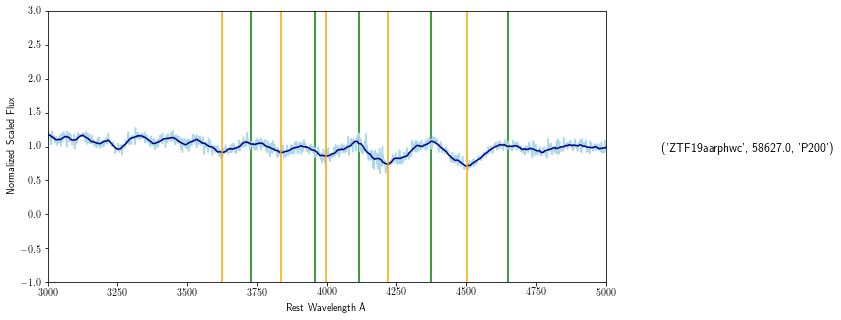

Eqivalent width for O1 is [252.27847132] Angstrom
Eqivalent width for O2 is [197.38454469] Angstrom
Eqivalent width for O3 is [193.88067703] Angstrom
Eqivalent width for O4 is [270.96576549] Angstrom
Eqivalent width for O5 is [246.43869189] Angstrom

 Velocity
824.2608135202202
1012.4961727255792
739.3050925093714
429.080082426748
521.2227969133855

 Rest_minima
10.241687886232793
13.364375732146444
10.14122045847261
6.2588052276565875
8.080186912776835

 Rest equivalent width
46.93168870983686
56.394857292444264
55.20762784356018
48.61948226252433
55.56357669172482


In [325]:
target_name = "ZTF19aarphwc"
spectrum = "ZTF19aarphwc_20190524_P200_v1.ascii"

normalize_spectra(target_name, spectrum, 3630, 3840, 4000, 4225, 4500)
equivalent_width(target_name, spectrum, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)
errors(target_name, spectrum, 3630, 3840, 4000, 4225, 4500, 3510, 3700, 3750, 3920, 3920, 4100, 4100, 4380, 4380, 4620)

ZTF19aarphwc

 Velocity
734.332356126736
937.3342384565699
794.5917629868067
389.287496249196
435.67132023155403

 Rest_minima
9.124299824581534
12.372280791558266
10.899600617634707
5.67836801653865
6.7539365523803

 Rest equivalent width
22.238041660222983
25.083051083498564
13.129444432263387
11.751367951482706
16.709213153653714


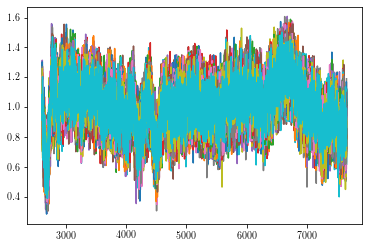

In [293]:
target_name = "ZTF19aarphwc"
spectrum = "ZTF19aarphwc_20190524_P200_v1.ascii"

for t in targets:
    
    if t == target_name:
    
        print (t)

        directory = glob.glob("data/new/%s/spectra/*.ascii"%t) #where the spectra are stored

        for d in directory: # go through all the spectra for a single source

            if d == "data/new/ZTF19aarphwc/spectra/%s"%spectrum:
        
                l = d.split("/")[4] # gets the ascii file name, ex:"ZTF18abszecm_20181213_P200_v3.ascii" from the entire string
                #print (l)    

                variable = l.split("_")[0]

                r = redshift[np.where(variable == targets)]
                z = 1 + r 

                data = ascii.read(d)    #read in the ascii file

                spectrum = Spectrum1D(flux =  data['col2']* u.Unit('W m-2 angstrom-1 sr-1'), spectral_axis = (data['col1']/z)*u.Angstrom)

                g1_fit = fit_generic_continuum(spectrum)

                y_continuum_fitted = g1_fit((data['col1']/z)* u.Angstrom)

                spec_normalized = spectrum / y_continuum_fitted
                yhat_1 = scipy.signal.savgol_filter(spec_normalized.flux, 51, 3)

                flux = spec_normalized.flux
                wavelength = spec_normalized.spectral_axis


                y_new =  flux - yhat_1
                
                #print (y_new)

                mean = np.median(y_new, axis = 0)
                std = np.std(y_new, axis = 0)

                #print (mean, std)

                N_samples = 100#number of random samples to draw for each x value

                shape = len(wavelength)

                y_array = np.zeros( (N_samples, shape) ) #Spectrum 1

                velocity1_arr = ( [] )
                velocity2_arr = ( [] )
                velocity3_arr = ( [] )
                velocity4_arr = ( [] )
                velocity5_arr = ( [] )

                Rest_min1_arr = ( [] )
                Rest_min2_arr = ( [] )
                Rest_min3_arr = ( [] )
                Rest_min4_arr = ( [] )
                Rest_min5_arr = ( [] )

                Observed_min1_arr = ([])
                Observed_min2_arr = ([])
                Observed_min3_arr = ([])
                Observed_min4_arr = ([])
                Observed_min5_arr = ([])

                Rest_L1min_arr = []
                Rest_L2min_arr = []
                Rest_L3min_arr = []
                Rest_L4min_arr = []
                Rest_L5min_arr = []

                Rest_L1max_arr = []
                Rest_L2max_arr = []
                Rest_L3max_arr = []
                Rest_L4max_arr = []
                Rest_L5max_arr = []

                Observed_L1min_arr = ([])
                Observed_L2min_arr = ([])
                Observed_L3min_arr = ([])
                Observed_L4min_arr = ([])
                Observed_L5min_arr = ([])

                Observed_L1max_arr = ([])
                Observed_L2max_arr = ([])
                Observed_L3max_arr = ([])
                Observed_L4max_arr = ([])
                Observed_L5max_arr = ([])

                Equivalent_width_Rest1 = []
                Equivalent_width_Rest2 = []
                Equivalent_width_Rest3 = []
                Equivalent_width_Rest4 = []
                Equivalent_width_Rest5 = []

                Equivalent_width_Observed1 = []
                Equivalent_width_Observed2 = []
                Equivalent_width_Observed3 = []
                Equivalent_width_Observed4 = []
                Equivalent_width_Observed5 = []

                #fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (10,5))
                #plt.plot(wavelength, y_new, color ='0.7')
                

                for i in range(N_samples):

                    #plt.xlim(3000,5000)
                    noise = np.random.normal(0, 0.1, len(yhat_1))

                    y = yhat_1 + noise

                    y_array[i] =  y

                    plt.plot(wavelength, y_array[i])

                    yhat = scipy.signal.savgol_filter(y_array[i], 51, 3)
    

                    O1 = np.where ((wavelength >  3575*u.Angstrom) & (wavelength < 3675*u.Angstrom))
                    O1_flux = min(yhat[O1])
                    O1_index = np.where(yhat == O1_flux)
                    O1_min = wavelength[O1_index]
                    O1_min2 = wavelength[O1_index]*z

                    velocity1 = (abs(O1_min - (3727.59*u.Angstrom))/(3727.59*u.Angstrom))*(3*pow(10,5))
                    velocity1_arr = np.append(velocity1_arr, velocity1)

                    Rest_min1_arr = np.append(Rest_min1_arr, O1_min)
                    Observed_min1_arr = np.append(Observed_min1_arr, O1_min2)

                    #print ("Rest_1: %s,"%O1_min, "Observed_1: %s,"%O1_min2, "Velocity is : %s km/s"%velocity1)
                    #print (velocity1)
                    #print (np.mean(velocity1_arr))

                    O2 = np.where ((wavelength >  3795*u.Angstrom) & (wavelength < 3895*u.Angstrom))
                    O2_flux = min(yhat[O2])
                    O2_index = np.where(yhat == O2_flux)
                    O2_min = wavelength[O2_index]
                    O2_min2 = wavelength[O2_index]*z

                    velocity2 = abs((O2_min /(3959.83*u.Angstrom))-1)*(3*pow(10,5))
                    velocity2_arr = np.append(velocity2_arr, velocity2)

                    Rest_min2_arr = np.append(Rest_min2_arr, O2_min)
                    Observed_min2_arr = np.append(Observed_min2_arr, O2_min2)

                    #print ("Rest_2: %s,"%O2_min, "Observed_2: %s,"%O2_min2, "Velocity is : %s km/s"%velocity2)

                    O3 = np.where ((wavelength >  3950*u.Angstrom) & (wavelength < 4050*u.Angstrom))
                    O3_flux = min(yhat[O3])
                    O3_index = np.where(yhat == O3_flux)
                    O3_min = wavelength[O3_index]
                    O3_min2 = wavelength[O3_index]*z
                    
                    #print (O3_min)

                    velocity3 = abs((O3_min/(4115.17*u.Angstrom))-1)*(3*pow(10,5))
                    velocity3_arr = np.append(velocity3_arr, velocity3)

                    Rest_min3_arr = np.append(Rest_min3_arr, O3_min)
                    Observed_min3_arr = np.append(Observed_min3_arr, O3_min2)

                    #print ("Rest_3: %s,"%O3_min, "Observed_3: %s,"%O3_min2, "Velocity is : %s km/s"%velocity3)

                    O4 = np.where ((wavelength >  4180*u.Angstrom) & (wavelength < 4280*u.Angstrom))
                    O4_flux = min(yhat[O4])
                    O4_index = np.where(yhat == O4_flux)
                    O4_min = wavelength[O4_index]
                    O4_min2 = wavelength[O4_index]*z

                    velocity4 = (abs(O4_min - (4375.97*u.Angstrom))/(4375.97*u.Angstrom))*(3*pow(10,5))
                    velocity4_arr = np.append(velocity4_arr, velocity4)

                    Rest_min4_arr = np.append(Rest_min4_arr, O4_min)
                    Observed_min4_arr = np.append(Observed_min4_arr, O4_min2)

                    #print ("Rest_4: %s,"%O4_min, "Observed_4: %s,"%O4_min2, "Velocity is : %s km/s"%velocity4)


                    O5 = np.where ((wavelength >  4460*u.Angstrom) & (wavelength < 4560*u.Angstrom))
                    O5_flux = min(yhat[O5])
                    O5_index = np.where(yhat == O5_flux)
                    O5_min = wavelength[O5_index]
                    O5_min2 = wavelength[O5_index]*z

                    velocity5 = (abs(O5_min - (4650.71*u.Angstrom))/(4650.71*u.Angstrom))*(3*pow(10,5))
                    velocity5_arr = np.append(velocity5_arr, velocity5)
                    Rest_min5_arr = np.append(Rest_min5_arr, O5_min)
                    Observed_min5_arr = np.append(Observed_min5_arr, O5_min2)

                    #print ("Rest_5: %s,"%O5_min, "Observed_5: %s,"%O5_min2, "Velocity is : %s km/s"%velocity5)



                    L1min = np.where ((wavelength >  3500*u.Angstrom) & (wavelength < 3540*u.Angstrom))
                    L1min_flux = max(yhat[L1min])
                    L1min_index = np.where(yhat == L1min_flux)
                    L1min_rest = wavelength[L1min_index]
                    L1min_observed = wavelength[L1min_index]*z

                    Rest_L1min_arr = np.append(Rest_L1min_arr, L1min_rest) 
                    Observed_L1min_arr = np.append(Observed_L1min_arr, L1min_observed) 

                    #print ("Rest_L1min: %s,"%L1min_rest, "Observed_L1min: %s"%L1min_observed)            

                    L1max = np.where ((wavelength >  3690*u.Angstrom) & (wavelength < 3770*u.Angstrom))
                    L1max_flux = max(yhat[L1max])
                    L1max_index = np.where(yhat == L1max_flux)
                    L1max_rest = wavelength[L1max_index]
                    L1max_observed = wavelength[L1max_index]*z

                    Rest_L1max_arr = np.append(Rest_L1max_arr, L1max_rest) 
                    Observed_L1max_arr = np.append(Observed_L1max_arr, L1max_observed) 

                    #print ("Rest_L1max: %s,"%L1max_rest, "Observed_L1max: %s"%L1max_observed)      
                    pEW1_rest = L1max_rest - L1min_rest
                    pEW1_observed = L1max_observed - L1min_observed

                    Equivalent_width_Rest1 = np.append(Equivalent_width_Rest1, pEW1_rest) 
                    Equivalent_width_Observed1 = np.append(Equivalent_width_Observed1, pEW1_observed) 

                    #print ("Eqivalent width for O1 from rest is %s," %pEW1_rest, "Eqivalent width for O1 from observed is %s" %pEW1_observed)



                    L2min = np.where ((wavelength >  3690*u.Angstrom) & (wavelength < 3770*u.Angstrom))
                    L2min_flux = max(yhat[L2min])
                    L2min_index = np.where(yhat == L2min_flux)
                    L2min_rest = wavelength[L2min_index]
                    L2min_observed = wavelength[L2min_index]*z

                    Rest_L2min_arr = np.append(Rest_L2min_arr, L2min_rest) 
                    Observed_L2min_arr = np.append(Observed_L2min_arr, L2min_observed)

                    #print ("Rest_L2min: %s,"%L2min_rest, "Observed_L2min: %s"%L2min_observed)

                    L2max = np.where ((wavelength >  3860*u.Angstrom) & (wavelength < 3930*u.Angstrom))
                    L2max_flux = max(yhat[L2max])
                    L2max_index = np.where(yhat == L2max_flux)
                    L2max_rest = wavelength[L2max_index]
                    L2max_observed = wavelength[L2max_index]*z

                    Rest_L2max_arr = np.append(Rest_L2max_arr, L2max_rest)
                    Observed_L2max_arr = np.append(Observed_L2max_arr, L2max_observed) 

                    #print ("Rest_L2max: %s,"%L2max_rest, "Observed_L2max: %s"%L2max_observed)

                    pEW2_rest = L2max_rest - L2min_rest
                    pEW2_observed = L2max_observed - L2min_observed

                    Equivalent_width_Rest2 = np.append(Equivalent_width_Rest2, pEW2_rest) 
                    Equivalent_width_Observed2 = np.append(Equivalent_width_Observed2, pEW2_observed) 

                    #print ("Eqivalent width for O2 from rest is %s," %pEW2_rest, "Eqivalent width for O2 from observed is %s" %pEW2_observed)


                    L3min = np.where ((wavelength >  3860*u.Angstrom) & (wavelength < 3930*u.Angstrom))
                    L3min_flux = max(yhat[L3min])
                    L3min_index = np.where(yhat == L3min_flux)
                    L3min_rest = wavelength[L3min_index]
                    L3min_observed = wavelength[L3min_index]*z

                    Rest_L3min_arr = np.append(Rest_L3min_arr, L3min_rest) 
                    Observed_L3min_arr = np.append(Observed_L3min_arr, L3min_observed)

                    #print ("Rest_L3min: %s,"%L3min_rest, "Observed_L3min: %s"%L3min_observed)

                    L3max = np.where ((wavelength >  4060*u.Angstrom) & (wavelength < 4130*u.Angstrom))
                    L3max_flux = max(yhat[L3max])
                    L3max_index = np.where(yhat == L3max_flux)
                    L3max_rest = wavelength[L3max_index]
                    L3max_observed = wavelength[L3max_index]*z

                    Rest_L3max_arr = np.append(Rest_L3max_arr, L3max_rest)
                    Observed_L3max_arr = np.append(Observed_L3max_arr, L3max_observed) 

                    #print ("Rest_L3max: %s,"%L3max_rest, "Observed_L3max: %s"%L3max_observed)

                    pEW3_rest = L3max_rest - L3min_rest
                    pEW3_observed = L3max_observed - L3min_observed

                    #print ("Eqivalent width for O3 from rest is %s," %pEW3_rest, "Eqivalent width for O3 from observed is %s" %pEW3_observed)

                    Equivalent_width_Rest3 = np.append(Equivalent_width_Rest3, pEW3_rest) 
                    Equivalent_width_Observed3 = np.append(Equivalent_width_Observed3, pEW3_observed) 

                    L4min = np.where ((wavelength >  4060*u.Angstrom) & (wavelength < 4130*u.Angstrom))
                    L4min_flux = max(yhat[L4min])
                    L4min_index = np.where(yhat == L4min_flux)
                    L4min_rest = wavelength[L4min_index]
                    L4min_observed = wavelength[L4min_index]*z

                    Rest_L4min_arr = np.append(Rest_L4min_arr, L4min_rest) 
                    Observed_L4min_arr = np.append(Observed_L4min_arr, L4min_observed)

                    #print ("Rest_L4min: %s," %L4min_rest, "Observed_L4min: %s" %L4min_observed )

                    L4max = np.where ((wavelength >  4340*u.Angstrom) & (wavelength < 4400*u.Angstrom))
                    L4max_flux = max(yhat[L4max])
                    L4max_index = np.where(yhat == L4max_flux)
                    L4max_rest = wavelength[L4max_index]
                    L4max_observed = wavelength[L4max_index]*z

                    Rest_L4max_arr = np.append(Rest_L4max_arr, L4max_rest)
                    Observed_L4max_arr = np.append(Observed_L4max_arr, L4max_observed) 

                    #print ("Rest_L4max: %s,"%L4max_rest, "Observed_L4max: %s"%L4max_observed)

                    pEW4_rest = L4max_rest - L4min_rest
                    pEW4_observed = L4max_observed - L4min_observed

                    #print ("Eqivalent width for O4 from rest is %s," %pEW4_rest, "Eqivalent width for O4 from observed is %s" %pEW4_observed)

                    Equivalent_width_Rest4 = np.append(Equivalent_width_Rest4, pEW4_rest) 
                    Equivalent_width_Observed4 = np.append(Equivalent_width_Observed4, pEW4_observed) 


                    L5min = np.where ((wavelength >  4340*u.Angstrom) & (wavelength < 4400*u.Angstrom))
                    L5min_flux = max(yhat[L5min])
                    L5min_index = np.where(yhat == L5min_flux)
                    L5min_rest = wavelength[L5min_index]
                    L5min_observed = wavelength[L5min_index]*z*z

                    Rest_L5min_arr = np.append(Rest_L5min_arr, L5min_rest) 
                    Observed_L5min_arr = np.append(Observed_L5min_arr, L5min_observed)

                    #print ("Rest_L5min: %s,"%L5min_rest, "Observed_5min: %s"%L5min_observed)

                    L5max = np.where ((wavelength >  4610*u.Angstrom) & (wavelength < 4650*u.Angstrom))
                    L5max_flux = max(yhat[L5max])
                    L5max_index = np.where(yhat == L5max_flux)
                    L5max_rest = wavelength[L5max_index]
                    L5max_observed = wavelength[L5max_index]*z

                    Rest_L5max_arr = np.append(Rest_L5max_arr, L5max_rest)
                    Observed_L5max_arr = np.append(Observed_L5max_arr, L5max_observed) 

                    #print ("Rest_L5max: %s,"%L5max_rest, "Observed_L5max: %s"%L5max_observed)

                    pEW5_rest = L5max_rest - L5min_rest
                    pEW5_observed = L5max_observed - L5min_observed

                    #print ("Eqivalent width for O5 from rest is %s," %pEW5_rest, "Eqivalent width for O5 from observed is %s" %pEW5_observed)

                    Equivalent_width_Rest5 = np.append(Equivalent_width_Rest5, pEW5_rest) 
                    Equivalent_width_Observed5 = np.append(Equivalent_width_Observed5, pEW5_observed) 


                    #plt.plot(wavelength, yhat, color ='darkblue')
                    #plt.show()
                
                #add = 0
                #mid = np.mean(velocity1_arr, axis = 0)
                
                #for i in velocity1_arr:
                    
                    #print (velocity1_arr)

                    #add = add + (velocity1_arr[i] - mid)
                    
                #std = np.sqrt(add/N_samples)
                #print (std)
                    
                print ("\n Velocity")
                
                #print (velocity1_arr)
                #print (np.mean(velocity1_arr, axis = 0))
                #print (np.mean(velocity2_arr, axis = 0))
                #print (np.mean(velocity3_arr, axis = 0))
                #print (np.mean(velocity4_arr, axis = 0))
                #print (np.mean(velocity5_arr, axis = 0))
                
                print (np.std(velocity1_arr, axis = 0))
                print (np.std(velocity2_arr, axis = 0))
                print (np.std(velocity3_arr, axis = 0))
                print (np.std(velocity4_arr, axis = 0))
                print (np.std(velocity5_arr, axis = 0))

                print ("\n Rest_minima")
                print (np.std(Rest_min1_arr, axis = 0))
                print (np.std(Rest_min2_arr, axis = 0))
                print (np.std(Rest_min3_arr, axis = 0))
                print (np.std(Rest_min4_arr, axis = 0))
                print (np.std(Rest_min5_arr, axis = 0))

                #print ("\n Rest_left_Limit")    
                #print (np.std(Rest_L1min_arr, axis = 0))
                #print (np.std(Rest_L2min_arr, axis = 0))
                #print (np.std(Rest_L3min_arr, ddof =1))
                #print (np.std(Rest_L4min_arr, ddof =1))
                #print (np.std(Rest_L5min_arr, ddof =1))

                #print ("\n Rest_right_Limit")
                #print (np.std(Rest_L1max_arr, ddof =1))
                #print (np.std(Rest_L2max_arr, ddof =1))
                #print (np.std(Rest_L3max_arr, ddof =1))
                #print (np.std(Rest_L4max_arr, ddof =1))
                #print (np.std(Rest_L5max_arr, ddof =1))

                print ("\n Rest equivalent width")
                print (np.std(Equivalent_width_Rest1, ddof =1))
                print (np.std(Equivalent_width_Rest2, ddof =1))
                print (np.std(Equivalent_width_Rest3, ddof =1))
                print (np.std(Equivalent_width_Rest4, ddof =1))
                print (np.std(Equivalent_width_Rest5, ddof =1))
                
            #plt.plot(wavelength, flux, color ='0.7')
            #plt.plot(wavelength, yhat_1, color ='0.2')
            
            #plt.show

In [423]:
user = "AishwaryaD"   #Marshal Username
passw = "bBrA@7592"   #Marshal Password
program_index = "10"  #program id for the program which contains the candidates you are interested in, 
                      #same program has different id for every different user 

# Where will the data be stored from this python run? 
date_directory= "new"#input
mkdir_date_dir = os.system("mkdir data/%s"%date_directory) # make a new directory where we will store the datapath


for target in targets:
    print (target)
    
    spectra = fetch_ZTF_spectrum(target, user, passw, program_idx=10) # Get the URLs of all available spectra for a source
    print (spectra)
    
    for spec in spectra:
        spec_download = download_spectra(spec, target, date_directory) # download all spectra to data path
        print (spec_download)
       
    out_files_path = glob.glob("data/%s/%s/spectra/*.ascii"%(date_directory, target))

ZTF18abszecm


KeyboardInterrupt: 